# Titanic: Machine Learning from Disaster
## Kaggle Competition

Author : Imanpal Singh<br>
Date Created : 09-06-20<br>
Last modified : 09-06-20

### Imports

In [1]:
## Pandas 1.0.3
import pandas as pd

## Matplotlib 3.1.3
from matplotlib import pyplot as plt

# Scikit-learn 0.22.1
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score,recall_score,f1_score



# Numpy 1.81.1
import numpy as np


### Data Loading

In [2]:
# Training dataset
train = pd.read_csv('train.csv')

# Test dataset
test = pd.read_csv('test.csv')

### Preprocessing for Analysis

#### Handling missing values

In [3]:
numRows = len(train.index)
## Percentage of missing values in columns
for column in train.columns:
    print("Missing values in {} : {}% "
          .format(column,train[column].isnull().sum()/numRows))

Missing values in PassengerId : 0.0% 
Missing values in Survived : 0.0% 
Missing values in Pclass : 0.0% 
Missing values in Name : 0.0% 
Missing values in Sex : 0.0% 
Missing values in Age : 0.19865319865319866% 
Missing values in SibSp : 0.0% 
Missing values in Parch : 0.0% 
Missing values in Ticket : 0.0% 
Missing values in Fare : 0.0% 
Missing values in Cabin : 0.7710437710437711% 
Missing values in Embarked : 0.002244668911335578% 


Droping `Cabin` - due to high percentage of missing values <br>
Dropping `passengerID`, `Name`, `Ticket` from domain knowledge

In [4]:
train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

#### Imputing Label Encoding and Scaling

In [5]:
## Seperating into Feature Matrix and vector of prediction
X = train.iloc[:,1:].values
y = train.iloc[:,0].values

In [6]:
# Imputing, LabelEncoding for analysis 
XAnalysis = X
XAnalysis[:,1],XAnalysis[:,6] = LabelEncoder().fit_transform(X[:,1]),LabelEncoder().fit_transform(X[:,5])
XAnalysis = SimpleImputer().fit_transform(XAnalysis)

In [7]:
# Separating for Plotting
died = XAnalysis[y==0]
survived = XAnalysis[y==1]
columns = train.columns[1:]


In [8]:
# Scaling for Principal Component Analaysis
XPca =  MinMaxScaler().fit_transform(XAnalysis)
XPca = PCA(n_components=2,random_state=20).fit_transform(XPca)

### Exploratory data Anlaysis

Text(0.5, 0.98, 'Titanic histogram')

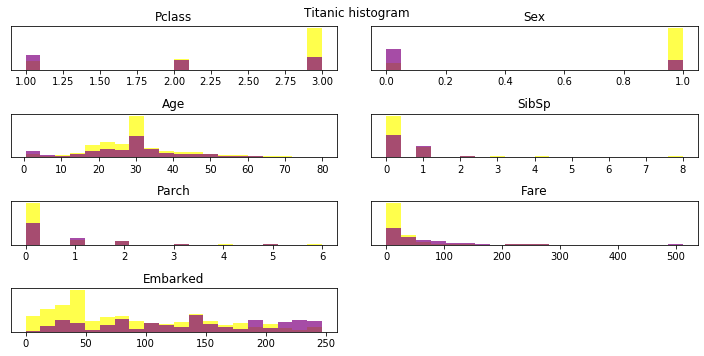

In [9]:
## Checking which features can help in classifying better between died and survived
fig,axes = plt.subplots(4,2, figsize=(10,5))
ax = axes.ravel()

for i in range(7):
    
    _,bins = np.histogram(XAnalysis[:,i],bins=20)
    ax[i].hist(died[:,i], bins=bins, color='yellow',alpha=0.7)
    ax[i].hist(survived[:, i], bins=bins, color='purple',alpha=0.7)
    ax[i].set_title(columns[i])
    ax[i].set_yticks(())
    
fig.tight_layout()
fig.delaxes(axes[3,1])
plt.suptitle("Titanic histogram")

#### Principal Component Analaysis

Text(0, 0.5, 'Second principal component')

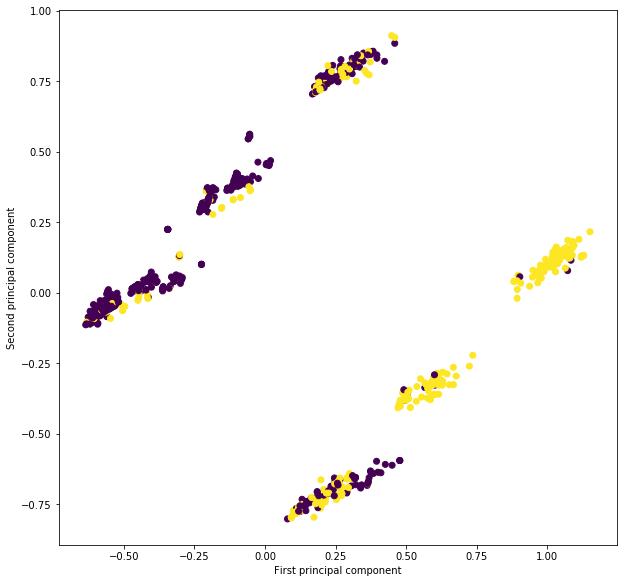

In [10]:
## Plotting principal component alnalysis n=2
plt.figure(figsize=(10,10))
plt.scatter(XPca[:, 0], XPca[:, 1], c=y)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

#### t-SNE

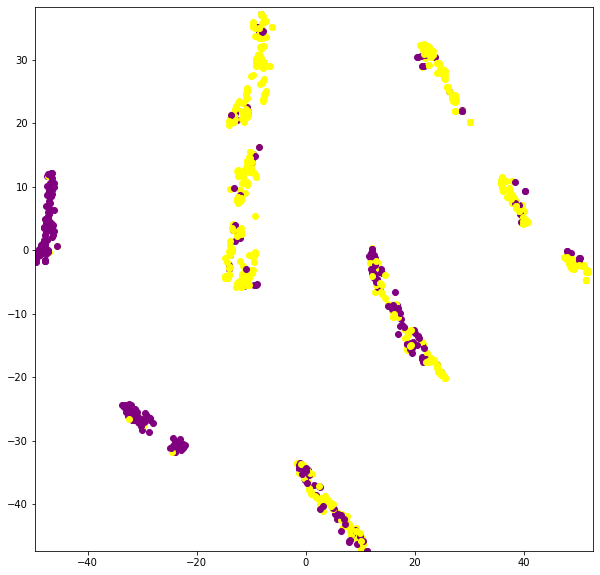

In [11]:
## t-SNE

tsne = TSNE(random_state=42)
XTsne = tsne.fit_transform(XPca)
plt.figure(figsize=(10, 10))
plt.xlim(XTsne[:, 0].min(), XTsne[:, 0].max() + 1)
plt.ylim(XTsne[:, 1].min(), XTsne[:, 1].max() + 1)

colors = ['yellow','purple']
for i in range(len(XAnalysis)):
    plt.scatter(XTsne[i, 0], XTsne[i, 1],color=colors[y[i]])


### Preprocessing for model building

In [12]:
# Getting dummies
#train = pd.get_dummies(train)

X = train.iloc[:,1:].values
y = train.iloc[:,0].values
# Splitting into training and test set
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size=0.08,stratify=y,random_state=20)

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=yTrain)
class_weights = {_class : class_weights[_class] for _class in range(len(class_weights))}

In [13]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Generating models

In [14]:
# Generally a pipeline would be better but Just keeping it simple this time

# Imputing missing values
catImpute = SimpleImputer(strategy='most_frequent')
catImpute = catImpute.fit(XTrain)

In [15]:
# Imputing
XTrain = catImpute.transform(XTrain)

In [16]:
# One hot encoding categorical features and scaling continuous ones
#(why did scikit-learn remove 'categorical_features' attribute -.-)
Continuous = XTrain[:,[2,5]]
Discrete = XTrain[:,[0,1,3,4,6]]
scaler =  MinMaxScaler()   # Donot scale for Tree based models
scaler.fit(Continuous)
Continuous = scaler.transform(Continuous)
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(Discrete)
Discrete = encoder.transform(Discrete)

In [17]:
#combining to form one array
XTrain = np.concatenate((Continuous,Discrete),axis=1)

In [18]:
# Creating a function for preprocessing test data
def PreprocessTest(Test):
    
    Test = catImpute.transform(Test)
    Continuous = Test[:,[2,5]]
    Discrete = Test[:,[0,1,3,4,6]]
    Discrete = encoder.transform(Discrete)
    return np.concatenate((Continuous,Discrete),axis=1)
    

In [19]:
XTest = PreprocessTest(XTest)

In [20]:
def precisionRecallF1Score(yTrue,yPred):
    
    print("Precision Score : {}".format(precision_score(yTrue,yPred)))
    print("Recall Score : {}".format(recall_score(yTrue,yPred)))
    print("F1 Score : {}".format(f1_score(yTrue,yPred)))
    

In [21]:
def classifier(clf):
    clf.fit(XTrain,yTrain)
    print("Test set score : ",clf.score(XTest,yTest))
    print("Train set score : ",clf.score(XTrain,yTrain))

    yPred = clf.predict(XTest)
    precisionRecallF1Score(yTest,yPred)
    
    return clf

### Building Model

In [33]:
# Random forest classifier ## Make sure scaling is not done
rfc = RandomForestClassifier(max_depth=8,n_jobs=-1,class_weight=class_weights,random_state=140)
rfc = classifier(rfc)


Test set score :  0.8194444444444444
Train set score :  0.9010989010989011
Precision Score : 0.8571428571428571
Recall Score : 0.6428571428571429
F1 Score : 0.7346938775510204


In [23]:
gbt = GradientBoostingClassifier(random_state=20)
gbt = classifier(gbt)

Test set score :  0.4027777777777778
Train set score :  0.9023199023199023
Precision Score : 0.39436619718309857
Recall Score : 1.0
F1 Score : 0.5656565656565656


In [24]:
dtc = DecisionTreeClassifier(max_depth = 3,random_state=20)
dtc = classifier(dtc)

Test set score :  0.8194444444444444
Train set score :  0.8205128205128205
Precision Score : 0.9411764705882353
Recall Score : 0.5714285714285714
F1 Score : 0.7111111111111111


In [25]:
# Support vector machine ## Make sure scaling is done
svmclf = SVC(class_weight=class_weights)
svmclf = classifier(svmclf)

Test set score :  0.3888888888888889
Train set score :  0.8168498168498168
Precision Score : 0.3888888888888889
Recall Score : 1.0
F1 Score : 0.56


In [26]:
nnclf = MLPClassifier(max_iter=1000,)
nnclf = classifier(nnclf)

Test set score :  0.7638888888888888
Train set score :  0.8400488400488401
Precision Score : 0.8235294117647058
Recall Score : 0.5
F1 Score : 0.6222222222222222


### Prediction

In [27]:
#test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True,errors='ignore')
#XNew = PreprocessTest(test.values)

In [28]:
# Chosing Randomforest  as prediciton
#predictions  = nnclf.predict(XNew)
#predictions = pd.DataFrame(predictions)
#predictions.index.rename('PassengerId',inplace=True)
#predictions.index +=892
#predictions.columns = ['Survived']

In [29]:
#predictions.to_csv('predictions.csv')